In [1]:
"""Trial run to see if waht would happen if we replace the fiber with a SiN waveguide,
     based on what currently QuantX is using for the clock."""

import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import laserfun as lf
from scipy.constants import c
import scipy.interpolate

%matplotlib notebook

# waveguide parameters
disp_file = 'Si3N4_oxideclad_thick-750nm_widths-0.4-3.9_wav-0.40-3.00um.npz'
width = 2.4      # micron
n2 = 2.0e-19     # m^2/W
Length = 25.00   # length in mm
Alpha = 0.00     # loss (dB/cm)
# Gamma = 1000   # nonlinearity (1/(W km)) can be manually added as well,  instead of using the gamma_function()
                 # need to change the parameter for gamma while creating fiber

# pulse parameters
FWHM = 0.200          # pulse duration (ps)
pulseWL = 1560        # pulse central wavelength (nm)

power = 0.006         # power (Watts)
rep_rate = 1e8        # repetition rate (Hz)

# energy per pulse
EPP = power/rep_rate  # enegry per pulse (J)
print(EPP)

# dispersion parameters
GDD = True            # Group delay dispersion (ps^2)
TOD = False           # Third order dispersion (ps^3)
FOD = False           # Fourth order dispersion

# simulation parameters
Window = 5.0     # simulation window (ps)
Steps = 100      # simulation steps
Points = 2**12   # simulation points
rtol = 1e-4      # relative error for NLSE integrator
atol = 1e-4      # absolute error
Raman = True     # Enable Raman effect?
Steep = True     # Enable self steepening?

# load the dispersion file:
data = np.load(disp_file)
wls = data['wav']*1e3
aeff_int = scipy.interpolate.interp1d(data['widths'], data['aeff'], axis=0)
neff_int = scipy.interpolate.interp1d(data['widths'], data['neff'], axis=0)

mismatch_int = scipy.interpolate.interp1d(data['widths'],data['mismatch'], axis=0)
dispersion_int = scipy.interpolate.interp1d(data['widths'],data['dispersion'], axis=0)

aeff = aeff_int(width)
neff = neff_int(width)

mismatch = mismatch_int(width)
dispersion = dispersion_int(width)


def disp_function(z=0):  # provide effective index to the NLSE
    return (wls, neff)


def gamma_function(z=0):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff)
    return 2*np.pi*n2/(pulseWL*1e-9*aeff_interp(pulseWL)*1e-12)


# create the pulse:
p = lf.Pulse(pulse_type='gaussian', length=Length, fwhm_ps=FWHM, center_wavelength_nm=pulseWL,
             time_window_ps=Window, GDD=GDD, TOD=TOD, FOD=FOD, power=0.272, power_is_avg=True, epp=EPP,
             npts=Points, RI=neff, wav=wls)

6e-11
1.3292362282266635e-06


   1.0% - 2.525e-04 m - 0.0 seconds
   2.0% - 5.051e-04 m - 0.0 seconds
   3.0% - 7.576e-04 m - 0.0 seconds
   4.0% - 1.010e-03 m - 0.0 seconds
   5.1% - 1.263e-03 m - 0.0 seconds
   6.1% - 1.515e-03 m - 0.0 seconds
   7.1% - 1.768e-03 m - 0.0 seconds
   8.1% - 2.020e-03 m - 0.0 seconds
   9.1% - 2.273e-03 m - 0.0 seconds
  10.1% - 2.525e-03 m - 0.0 seconds
  11.1% - 2.778e-03 m - 0.0 seconds
  12.1% - 3.030e-03 m - 0.0 seconds
  13.1% - 3.283e-03 m - 0.0 seconds
  14.1% - 3.535e-03 m - 0.0 seconds
  15.2% - 3.788e-03 m - 0.0 seconds
  16.2% - 4.040e-03 m - 0.0 seconds
  17.2% - 4.293e-03 m - 0.0 seconds
  18.2% - 4.545e-03 m - 0.0 seconds
  19.2% - 4.798e-03 m - 0.0 seconds
  20.2% - 5.051e-03 m - 0.0 seconds
  21.2% - 5.303e-03 m - 0.0 seconds
  22.2% - 5.556e-03 m - 0.0 seconds
  23.2% - 5.808e-03 m - 0.0 seconds
  24.2% - 6.061e-03 m - 0.0 seconds
  25.3% - 6.313e-03 m - 0.0 seconds
  26.3% - 6.566e-03 m - 0.0 seconds
  27.3% - 6.818e-03 m - 0.0 seconds
  28.3% - 7.071e-03 m - 0.0 

<IPython.core.display.Javascript object>


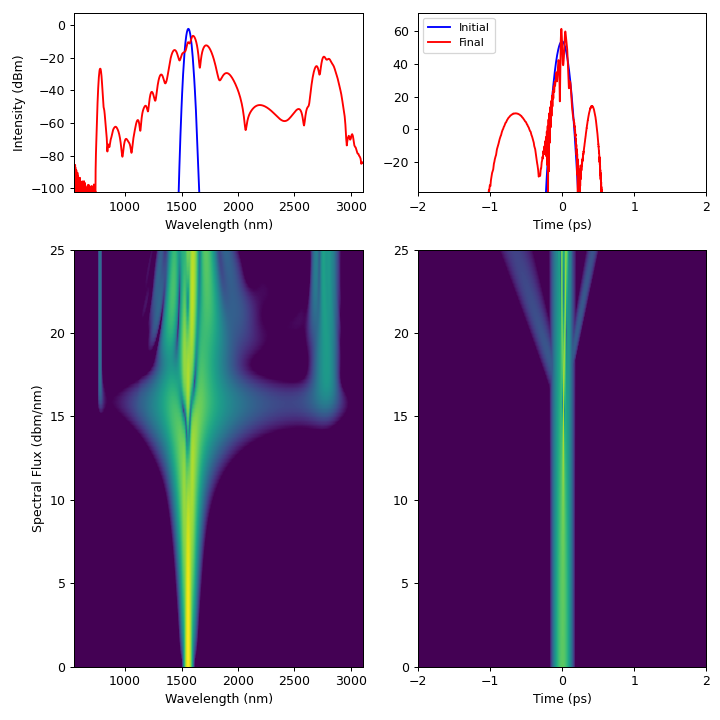

(<Figure size 800x800 with 4 Axes>,
 array([[<AxesSubplot:xlabel='Wavelength (nm)', ylabel='Intensity (dBm)'>,
         <AxesSubplot:xlabel='Time (ps)'>],
        [<AxesSubplot:xlabel='Wavelength (nm)', ylabel='Spectral Flux (dbm/nm)'>,
         <AxesSubplot:xlabel='Time (ps)'>]], dtype=object))

In [2]:
# create the fiber
f = lf.Fiber(Length * 1e-3, center_wl_nm=pulseWL, dispersion_format='GVD',
             gamma_W_m=gamma_function(), loss_dB_per_m=Alpha*100)

f.set_dispersion_function(disp_function, dispersion_format='n')

# propagate the pulse using the NLSE
results = lf.NLSE(p, f, raman=Raman, shock=Steep, nsaves=Steps, rtol=rtol,
                  atol=atol, print_status=True)

results.plot(wavelength=True, show=True, tlim=(-2, 2))